In [4]:
import warnings
from sklearn.model_selection import KFold

import pickle
import gc
import datetime

from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

warnings.filterwarnings("ignore")
"""
all parameters and configurations
"""
train_path='h:\\machine_learning\\transaction_fraud\\train_transaction.csv'
identity_path = 'h:\\machine_learning\\transaction_fraud\\train_identity.csv'

n_estimator = 100
max_depth = 10
seed = 10
n_jobs = -1
stop_rounds = 1000
k_folds = 5
verbose = 500


def load_data(path):
    df = pd.read_csv(path) # this is main table
    return df

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':'auc',
        'learning_rate': 0.02,
        #'is_unbalance': 'true',
        'scale_pos_weight': 9, # because training data is extremely unbalanced
        'nthread': 4,
        #'metric': 'binary_logloss'
    }


def model_lgb_classifier():
    model = lgb.LGBMClassifier(**lgb_params)
    return model

def model_lgb_default():
    model = lgb.LGBMClassifier()
    return model


def model_KNeighborsClassifier():
    model = KNeighborsClassifier(n_neighbors=10, n_jobs=4)

    return model

def drop_corr_column(df):
    print("Start drop corr columns ...")
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    # Drop features
    df.drop(df[to_drop], axis=1, inplace=True)
    print(df.info())

# Function to clean the names
def assign_region(email_addr):
    REGION = {
        ".jp": "Japan",
        ".fr": "French",
        ".uk": "UK",
        ".mx": "Mexico",
        ".de": "German",
        ".es": "Spain",
        ".com": "Global",
        ".net": "Global"
    }
    for key in REGION.keys():
        if email_addr.find(key) != -1:
            return REGION[key]


def handl_P_emaildomain(train_df):
    print("start to handle  P_emaildomain...")
    # process NaN value
    train_df['P_emaildomain'].fillna('TBD', inplace=True)
    #create a new column
    train_df = train_df.assign(Region_emaildomain=train_df['P_emaildomain'])
    # process P_emaildomain column
    train_df.loc[train_df['P_emaildomain'] == 'TBD', 'Region_emaildomain'] = 'Global'
    train_df.loc[train_df['P_emaildomain'] == 'yahoo', 'P_emaildomain'] = 'yahoo.com'
    train_df.loc[train_df['P_emaildomain'] == 'gmail', 'P_emaildomain'] = 'gmail.com'
    train_df['Region_emaildomain'] = train_df['Region_emaildomain'].apply(assign_region)
    print(train_df['Region_emaildomain'].head())

def handle_NaN(train_df):
    # Check for Nan amount in every column
    print("start to handle NaN ...")
    nan_info = pd.DataFrame(train_df.isnull().sum()).reset_index()
    nan_info.columns = ['col', 'nan_cnt']
    nan_info.sort_values(by='nan_cnt', ascending=False, inplace=True)
    # Columns with missing values
    cols_with_missing = nan_info.loc[nan_info.nan_cnt > 0].col.values
    # Fill missing values (numbers) with the median
    for f in cols_with_missing:
        if str(train_df[f].dtype) != 'object':
            train_df[f].fillna(train_df[f].median(), inplace=True)
    # Fill missing values (objects) with Unknown
    for f in cols_with_missing:
        if str(train_df[f].dtype) == 'object':
            train_df[f].fillna('Unknown', inplace=True)
    # Check if there are still Nan values
    nan_info = pd.DataFrame(train_df.isnull().sum()).reset_index()
    nan_info.columns = ['col', 'nan_cnt']
    nan_info.sort_values(by='nan_cnt', ascending=False, inplace=True)
    print(nan_info)

def transfer_cat_2_int(train_df):
    print("Start transfer categorical values to integer ...")
    category_columns = train_df.select_dtypes(include=['category', object]).columns
    for f in category_columns:
        train_df[f] = train_df[f].astype(str)
        le = LabelEncoder()
        train_df[f] = le.fit_transform(train_df[f])

def train_KNeighborsClassifier(X_train, y_train):
    print("Start to train KNeighborsClassifier ....")
    train = X_train.to_numpy()
    target = y_train.to_numpy()

    y = target
    X = train
    # Scaling data (KNeighbors methods do not scale automatically!)
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X)
    # Splitting dataset
    X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.35)

    knn = KNeighborsClassifier(n_neighbors=10, n_jobs=4)
    knn.fit(X_train, y_train)
    y_predicted = knn.predict(X_test)
    f1_scores = f1_score(y_test, y_predicted, average="macro")
    error_rate = np.mean(y_predicted != y_test)
    return f1_scores, error_rate

def drop_selected_feature(train_txn):
    features = ['V322', 'V323', 'V326', 'V330', 'V331', 'V333', 'V334', 'V336', 'V337', 'V339',
     'V2', 'V4', 'V6', 'V8', 'V11', 'V324', 'V329', 'V300', 'V10', 'V16', 'V17', 'V22', 'V27', 'V29', 'V31', 'V33',
     'V35', 'V39', 'V42', 'V48', 'V51', 'V57', 'V59', 'V63', 'V69', 'V71', 'V73', 'V80', 'V84', 'V90', 'V92', 'V96', 'V103', 'V105', 'V127',
     'V139', 'V148', 'V153', 'V155', 'V150', 'V178', 'V182', 'V192', 'V204', 'V212', 'V219', 'V224', 'V233', 'V248',
     'V221', 'V238', 'V250', 'V255', 'V272', 'V295', 'V299', 'V308', 'V318']
    for f in features:
        train_txn.drop([f], axis=1,inplace=True)


def other_feature_engineering(train_txn):
    train_txn['TransactionDT']= datetime.datetime.fromtimestamp(train_txn['TransactionDT'][0]).strftime("%A, %B %d, %Y %I:%M:%S")

    cut_labels = ['1', '2', '3', '4']
    cut_bins = [0, 200, 300, 400, train_txn['addr1'].max()]
    train_txn['addr1'] = pd.cut(train_txn['addr1'], bins=cut_bins, labels=cut_labels)

    cut_labels = ['1', '2', '3', '4', '5']
    cut_bins = [0, 20, 40, 60, 80, train_txn['addr2'].max()]
    train_txn['addr2'] = pd.cut(train_txn['addr2'], bins=cut_bins, labels=cut_labels)

    cut_labels = ['1', '2', '3', '4', '5', '6']
    cut_bins = [0, 4001, 7001, 10000, 13000, 16000, train_txn['card1'].max()]
    train_txn['card1'] = pd.cut(train_txn['card1'], bins=cut_bins, labels=cut_labels)

    cut_labels = ['1', '2', '3', '4', '5']
    cut_bins = [0, 200, 300, 400, 500, train_txn['card2'].max()]
    train_txn['card2'] = pd.cut(train_txn['card2'], bins=cut_bins, labels=cut_labels)


###############################



2020-02-21 22:36:04.800439
Start to load datasets ...
(10000, 394) (10000, 41)
Drop target column, merge two tables. the new shape of main table: (10000, 394)
start to handle  P_emaildomain...
0      None
1    Global
2    Global
3    Global
4    Global
Name: Region_emaildomain, dtype: object
start to handle NaN ...
               col  nan_cnt
0    TransactionID        0
285           V232        0
296           V243        0
295           V242        0
294           V241        0
..             ...      ...
141            V88        0
140            V87        0
139            V86        0
138            V85        0
432     DeviceInfo        0

[433 rows x 2 columns]
Start transfer categorical values to integer ...
Memory usage of dataframe is 32.05 MB
Memory usage after optimization is: 8.37 MB
Decreased by 73.9%
Train lightGBM Default
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=-1

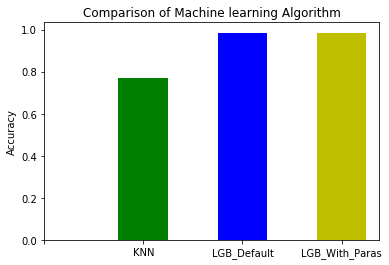

In [5]:
    print(datetime.datetime.now())
    print("Start to load datasets ...")
    train_df = load_data(train_path)
    identity_df = load_data(identity_path)

    # # TEST
    train_df = train_df[:10000]
    identity_df = identity_df[:10000]
    # # TEST
    print(train_df.shape,identity_df.shape)

    print("Drop target column, merge two tables. the new shape of main table:", train_df.shape)
    target = train_df['isFraud']
    train_df.drop(['isFraud'], axis=1, inplace=True)
    train_df = train_df.merge(identity_df, on='TransactionID', how='left')

    handl_P_emaildomain(train_df)

    handle_NaN(train_df)

    other_feature_engineering(train_df)

    transfer_cat_2_int(train_df)

#    drop_corr_column(train_df)
#    drop_selected_feature(train_df)



    reduce_mem_usage(train_df)

    # train knn model and get result
    # f1_scores, error_rate = train_KNeighborsClassifier(train_df, target)
    # print(f1_scores, error_rate)

    # train knn model and get result
    X = train_df
    y = target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1000)

    # model_name = 'lgb'
    # train_model(model_name=model_name, X_train=X_train, y_train=y_train)
    # print('model lightGBM training done')
    ##################################################################
    # fit a lightGBM model to the data
    classifiers = [
        ("lightGBM Default", model_lgb_classifier()),
        ("lightGBM with Parameter", model_lgb_default())
    ]
    Accuracy   =[0.77]   # KNN accuracy, need 10 hours to train
    for name, model in classifiers:
        print("Train %s" % name)
        model.fit(X_train, y_train)
        print(model)
        # make predictions
        expected_y = y_test
        predicted_y = model.predict(X_test)
        # summarize the fit of the model
        print(metrics.classification_report(expected_y, predicted_y))
        print(metrics.confusion_matrix(expected_y, predicted_y))
        accuracy = metrics.classification_report(expected_y, predicted_y, output_dict=True)
        Accuracy.append(accuracy["accuracy"])

    print(datetime.datetime.now())
    algs = ['','KNN', 'LGB_Default', 'LGB_With_Paras']
    num = [1,2,3]
    x_pos =  [i for i, _ in enumerate(algs)]
    plt.bar( num, Accuracy, color=["g","b","y"],width = 0.5)
    plt.ylabel("Accuracy")
    plt.title("Comparison of Machine learning Algorithm")
    plt.xticks(x_pos, algs)
    plt.show()
